In [ ]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import networkx as nx
import os
from itertools import product

from tqdm import tqdm


import geopandas as gpd
from shapely.geometry import Point
import pyproj
pyproj.datadir.set_data_dir('/usr/local/share/proj')
from pyproj import CRS, Transformer

import matplotlib as mpl        
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import folium

### Load data

In [2]:
source = '/mnt/raw_data/'

In [3]:
files_events = np.array( sorted([ i for i in os.listdir(source) if 'EVENTS' in i]) )
files_poligons = np.array( sorted([ i for i in os.listdir(source) if 'POLIGONS' in i]) )
files_events.shape, files_poligons.shape

((365,), (365,))

### Investigate polygons file

In [4]:
source+files_poligons[100]

'/mnt/raw_data/MT_MTA_NETWORK_POLIGONS_20190311.csv.gz'

In [5]:
poligons_df = pd.read_csv( source+files_poligons[100], delimiter=';' )
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type
0,10071347,216918,496318,127,127,D
1,10071347,216918,496445,127,127,D
2,10071347,217045,496191,127,127,D
3,10071347,217045,496318,127,127,D
4,10071347,217045,496572,127,127,D


In [6]:
poligons_df.tail()

,network_identifier,eovx,eovy,dx,dy,network_element_type
26053295,99591498,195455,562739,127,127,D
26053296,99591498,195455,562866,127,127,D
26053297,99591498,195455,562993,127,127,D
26053298,99591498,195582,562739,127,127,D
26053299,99591498,195709,562612,127,127,D


In [7]:
poligons_df.shape

(26053300, 6)

In [8]:
np.unique( poligons_df.network_identifier ).shape

(43155,)

#### Choose a specific tower

In [9]:
poligons_df[ (poligons_df.network_identifier.values == 72922) ]

,network_identifier,eovx,eovy,dx,dy,network_element_type
23226044,72922,241429,549658,127,127,B
23226045,72922,241683,548515,127,127,B
23226046,72922,241810,548515,127,127,B
23226047,72922,241810,548642,127,127,B
23226048,72922,241810,549277,127,127,B
...,...,...,...,...,...,...
23227972,72922,253240,550928,127,127,B
23227973,72922,253367,548134,127,127,B
23227974,72922,253367,548261,127,127,B
23227975,72922,253367,550801,127,127,B


#### Coordinate system transformation, checking boundaries

In [10]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
crs_eov, crs_lonlat

(<Projected CRS: EPSG:23700>
 Name: HD72 / EOV
 Axis Info [cartesian]:
 - Y[east]: Easting (metre)
 - X[north]: Northing (metre)
 Area of Use:
 - name: Hungary.
 - bounds: (16.11, 45.74, 22.9, 48.58)
 Coordinate Operation:
 - name: Egyseges Orszagos Vetuleti
 - method: Hotine Oblique Mercator (variant B)
 Datum: Hungarian Datum 1972
 - Ellipsoid: GRS 1967
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

Center coordinates
- 684692.78 201865.84

Projected bounds:
- 421391.21 48212.58
- 934220.63 366660.88

WGS84 bounds:
- 16.11 45.74
- 22.9 48.58

These values define the official bounding box:
- eov_bottom_left_x = uint32(48210)
- eov_bottom_left_y = uint32(421391)
- eov_top_right_x   = uint32(366660)
- eov_top_right_y   = uint32(934219)

However, these values are based on the bounding box defined by the actual coordinate values found in the polygon files. Some rasters just fall outside the real eov system.
- eov_bottom_left_x = uint32(43944)  // Southern edge.
- eov_bottom_left_y = uint32(426341) // Western edge.
- eov_top_right_x   = uint32(362968) // Northern edge.
- eov_top_right_y   = uint32(937262) // Eastern edge.

#### Need to swap axis! do not forget in order to avoid bad results!

In [11]:
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

In [12]:
transformer.transform(421391, 48210), transformer.transform(934219, 366660)

((45.739976745490914, 16.10999855601422),
 (48.5799928138954, 22.899977298277413))

#### Check other transform tool, too

In [13]:
import ogr, osr

pointX = 421391
pointY = 48210

# Spatial Reference System
inputEPSG = 23700
outputEPSG = 4326

# create a geometry from coordinates
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(pointX, pointY)

# create coordinate transformation
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromEPSG(inputEPSG)

outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(outputEPSG)

coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

# transform point
point.Transform(coordTransform)

# print point in EPSG 4326
print(point.GetX(), point.GetY())

16.109998556014194 45.739976745490935


In [14]:
poligons_df.eovx.values.min(), poligons_df.eovx.values.max()

(43944, 362968)

In [15]:
poligons_df.eovy.values.min(), poligons_df.eovy.values.max()

(426341, 937262)

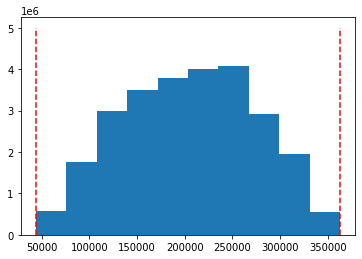

In [16]:
plt.hist( poligons_df.eovx.values )
plt.vlines( 43944, 0, 5e6, color='r', linestyles='--' )
plt.vlines( 362968, 0, 5e6, color='r', linestyles='--' )

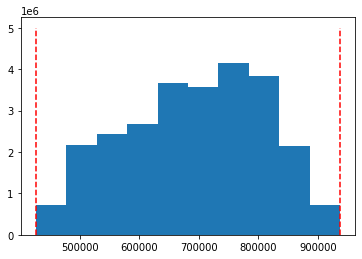

In [17]:
plt.hist( poligons_df.eovy.values )
plt.vlines( 426341, 0, 5e6, color='r', linestyles='--' )
plt.vlines( 937262, 0, 5e6, color='r', linestyles='--' )

#### Conclusion: some fall outside of the official boundaries!

### Leave out that fall outside

In [18]:
poligons_df = poligons_df[ np.logical_and( poligons_df.eovx.values < 366660, poligons_df.eovx.values > 48210 ) ]
poligons_df = poligons_df[ np.logical_and( poligons_df.eovy.values < 934219, poligons_df.eovy.values > 426341 ) ]
poligons_df.shape

(26042098, 6)

In [19]:
tower_df = poligons_df[ (poligons_df.network_identifier.values == 72922) ]
tower_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type
23226044,72922,241429,549658,127,127,B
23226045,72922,241683,548515,127,127,B
23226046,72922,241810,548515,127,127,B
23226047,72922,241810,548642,127,127,B
23226048,72922,241810,549277,127,127,B


### Transorm between systems

In [20]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

#### Check transform: https://epsg.io/transform#s_srs=23700&t_srs=4326&x=216918.0000000&y=496318.0000000

In [21]:
transformer.transform(216918, 496318), transformer.transform(216918, 496318)

((49.65857976373628, 13.048916733920567),
 (49.65857976373628, 13.048916733920567))

In [22]:
X = poligons_df[ (poligons_df.network_identifier.values == 10071347) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 10071347) ].eovy.values
print( X.shape, Y.shape )

lat, lon = transformer.transform(xx=X, yy=Y)
lat.min(), lat.max(), lon.min(), lon.max()

(5252,) (5252,)


(49.51319914977651, 49.74183384639603, 13.048781946668246, 13.356220137001475)

### Visualization of rasters that belongs to a tower

(215775.0, 239524.0, 477807.75, 506446.25)

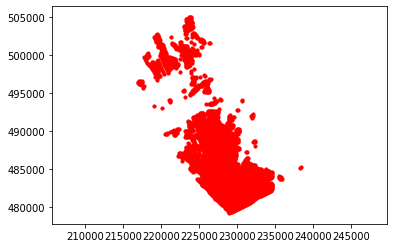

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

(137,) (137,)


(287358.55, 289733.45, 825870.3, 827546.7)

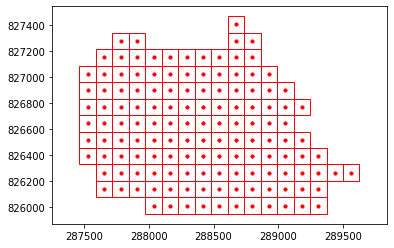

In [24]:
X = poligons_df[ (poligons_df.network_identifier.values == 553841622) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 553841622) ].eovy.values
print( X.shape, Y.shape )

lat, lon = transformer.transform(xx=X, yy=Y)
lat.min(), lat.max(), lon.min(), lon.max()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

(1933,) (1933,)


(240755.9, 254167.1, 544889.15, 553410.85)

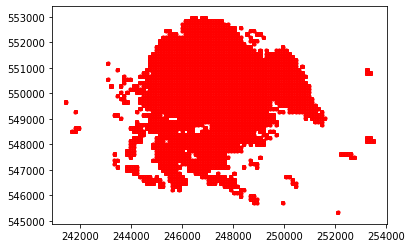

In [25]:
X = poligons_df[ (poligons_df.network_identifier.values == 72922) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 72922) ].eovy.values
print( X.shape, Y.shape )

lat, lon = transformer.transform(xx=X, yy=Y)
lat.min(), lat.max(), lon.min(), lon.max()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

(37,) (37,)


(225414.3, 227090.7, 653518.6, 655474.4)

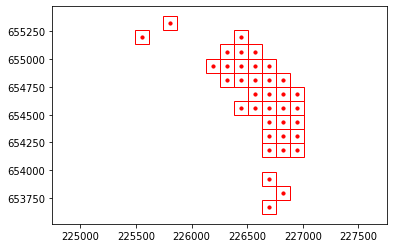

In [26]:
X = poligons_df[ (poligons_df.network_identifier.values == 229021) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 229021) ].eovy.values
print( X.shape, Y.shape )

lat, lon = transformer.transform(xx=X, yy=Y)
lat.min(), lat.max(), lon.min(), lon.max()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

#### Lets see what are the typical numbers of rasters that belongs to a tower

Text(0.5, 0, 'Number of rasters')

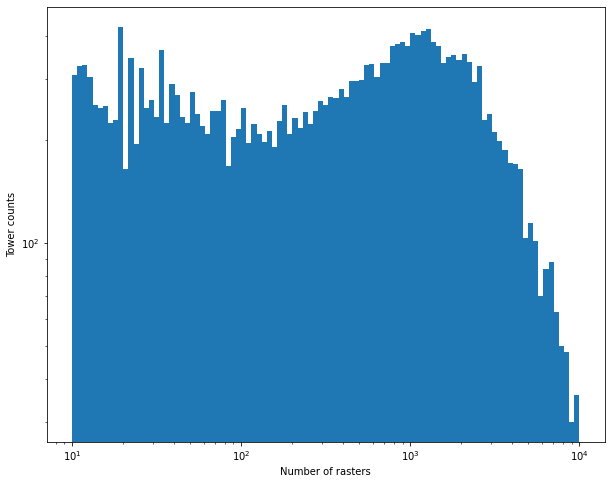

In [27]:
logbins = np.logspace( np.log10(10), np.log10(1e4), 100)
plt.figure( figsize=(10,8) )
plt.hist( poligons_df.groupby( by='network_identifier' ).count().network_element_type.values, bins=logbins  )
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tower counts')
plt.xlabel('Number of rasters')

#### Average number of rasters associated with one tower

In [28]:
 poligons_df.groupby( by='network_identifier' ).count().network_element_type.values.mean()

603.566829675296

#### Calculated average boxside would be

In [29]:
np.sqrt(603*127*127)

3118.6194060834036

Text(0.5, 0, 'Area of a tower [$m^2$]')

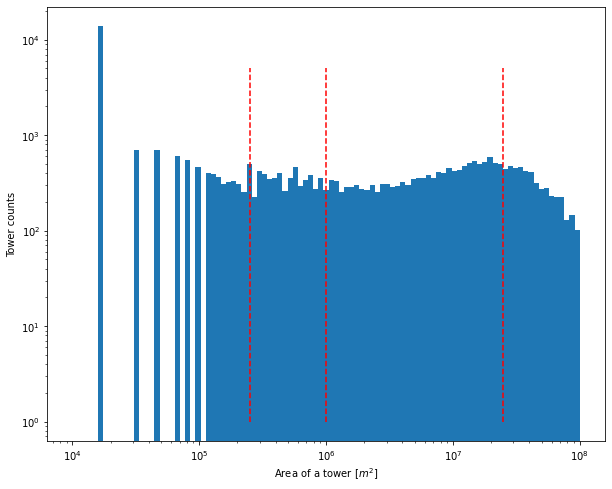

In [30]:
logbins = np.logspace( np.log10(1e4), np.log10(1e8), 100)
plt.figure( figsize=(10,8) )
plt.hist( (poligons_df.groupby( by='network_identifier' ).count().network_element_type.values)*127*127, bins=logbins )
plt.vlines( 500*500, 1e0, 5e3, color='red', linestyles='--' )
plt.vlines( 1000*1000, 1e0, 5e3, color='red', linestyles='--' )
plt.vlines( 5000*5000, 1e0, 5e3, color='red', linestyles='--' )
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Tower counts')
plt.xlabel('Area of a tower [$m^2$]')

#### The marked vertical lines are denoting the area of a box in case of
- 500 m boxside
- 1000 m boxside
- 5000 m boxside

### Create coordinate system

In [31]:
poligons_df.eovx.values.min(), poligons_df.eovx.values.max()

(48262, 362968)

In [32]:
poligons_df.eovy.values.min(), poligons_df.eovy.values.max()

(426468, 934214)

In [33]:
(362968-48262)/127, (934214-426468)/127

(2478.0, 3998.0)

In [34]:
2500*4000 / 1e6

10.0

#### Lets define a coordinate system of the small rasters

In [35]:
start_x = poligons_df.eovx.values.min()
start_y = poligons_df.eovy.values.min()
end_x = poligons_df.eovx.values.max()
end_y = poligons_df.eovy.values.max()
num_x = int( ( end_x - start_x ) / 127 )
num_y = int( ( end_y - start_y ) / 127 )
raster_x = np.arange(start_x, end_x+127, 127, dtype=np.int32)
raster_y = np.arange(start_y, end_y+127, 127, dtype=np.int32)
raster_x.shape, raster_y.shape # shapes should be one more than num!

((2479,), (3999,))

##### All coordinates

In [36]:
raster_coords = np.array( list(product( raster_x, raster_y )) )
raster_coords[:3], raster_coords.shape

(array([[ 48262, 426468],
        [ 48262, 426595],
        [ 48262, 426722]], dtype=int32),
 (9913521, 2))

##### Building blocks of the coordinates, structure revealed, no need to search for values in df

In [37]:
raster_coords[:,0].reshape( -1, (num_y+1) )[:3] # indexing: i * cols + j

array([[48262, 48262, 48262, ..., 48262, 48262, 48262],
       [48389, 48389, 48389, ..., 48389, 48389, 48389],
       [48516, 48516, 48516, ..., 48516, 48516, 48516]], dtype=int32)

In [38]:
poligons_df.loc[0]

network_identifier      10071347
eovx                      216918
eovy                      496318
dx                           127
dy                           127
network_element_type           D
Name: 0, dtype: object

In [39]:
raster_coords[ int((poligons_df.eovx[0] - start_x) / 127)*(num_y+1) + \
               int((poligons_df.eovy[0] - start_y) / 127) ]

array([216918, 496318], dtype=int32)

#### Extend poligons dataframe 

In [40]:
poligons_df['eovx_num'] = ( (poligons_df.eovx - start_x) / 127 ).astype(int)
poligons_df['eovy_num'] = ( (poligons_df.eovy - start_y) / 127 ).astype(int)
poligons_df['eov_idx'] = poligons_df.eovx_num * (num_y+1) + poligons_df.eovy_num
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type,eovx_num,eovy_num,eov_idx
0,10071347,216918,496318,127,127,D,1328,550,5311222
1,10071347,216918,496445,127,127,D,1328,551,5311223
2,10071347,217045,496191,127,127,D,1329,549,5315220
3,10071347,217045,496318,127,127,D,1329,550,5315221
4,10071347,217045,496572,127,127,D,1329,552,5315223


In [41]:
tower_id = np.unique( poligons_df.network_identifier.values )
tower_id[:5], tower_id.shape

(array([ 71892,  72307,  72922,  73325, 140903]), (43147,))

In [42]:
uniq, counts = np.unique(poligons_df.eov_idx, return_counts=True)

In [43]:
counts.min(), counts.max(), counts.sum(), poligons_df.shape[0]

(1, 107, 26042098, 26042098)

### How many overlaps occur

Text(0.5, 0, 'Number of polygons the raster belogs to')

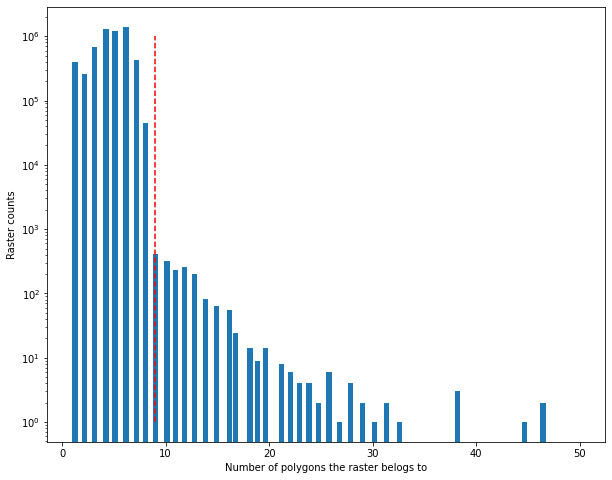

In [44]:
logbins = np.logspace( np.log10(1), np.log10(5e1), 100)
plt.figure( figsize=(10,8) )
plt.hist( counts, bins=logbins, width=0.5  )
plt.vlines(9, 1e0, 1e6, color='r', linestyles='--')
#plt.xscale('log')
plt.yscale('log')
plt.ylabel('Raster counts')
plt.xlabel('Number of polygons the raster belogs to')

#### Typically there are 1-8 overlaps 

### Investigate events

In [45]:
events_df = pd.read_csv( source+files_events[100], delimiter=';' )
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,country_code,device_tac
0,929,5C800002,22314009,V,O,216,35177706.0
1,934,5C800002,22314009,V,O,216,35177706.0
2,1142,5C800002,22314009,V,O,216,35177706.0
3,1147,5C800002,22314009,V,O,216,35177706.0
4,158,5C800003,325471968,D,O,216,35337609.0


In [46]:
events_df.shape[0]/1e6

150.130928

#### Add integer coded towers to dataframes

In [47]:
tower_to_int = dict(zip( tower_id, np.arange(tower_id.shape[0]) ))

In [48]:
poligons_df["tower_idx"] = [ tower_to_int[i] for i in poligons_df.network_identifier.values ]
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type,eovx_num,eovy_num,eov_idx,tower_idx
0,10071347,216918,496318,127,127,D,1328,550,5311222,9069
1,10071347,216918,496445,127,127,D,1328,551,5311223,9069
2,10071347,217045,496191,127,127,D,1329,549,5315220,9069
3,10071347,217045,496318,127,127,D,1329,550,5315221,9069
4,10071347,217045,496572,127,127,D,1329,552,5315223,9069


In [49]:
events_df["tower_idx"] = [ tower_to_int[i] for i in events_df.network_identifier.values ]
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,country_code,device_tac,tower_idx
0,929,5C800002,22314009,V,O,216,35177706.0,10651
1,934,5C800002,22314009,V,O,216,35177706.0,10651
2,1142,5C800002,22314009,V,O,216,35177706.0,10651
3,1147,5C800002,22314009,V,O,216,35177706.0,10651
4,158,5C800003,325471968,D,O,216,35337609.0,39888


#### Sort polygons df in order to use a much quicker searching method (gain 1000x speed!)

In [50]:
poligons_df.sort_values( by='tower_idx', inplace=True )

In [51]:
poligons_df.head()

,network_identifier,eovx,eovy,dx,dy,network_element_type,eovx_num,eovy_num,eov_idx,tower_idx
23099845,71892,256034,557659,127,127,B,1636,1033,6543397,0
23098519,71892,251208,560834,127,127,B,1598,1058,6391460,0
23098520,71892,251208,560961,127,127,B,1598,1059,6391461,0
23098521,71892,251208,561088,127,127,B,1598,1060,6391462,0
23098522,71892,251208,561215,127,127,B,1598,1061,6391463,0


### -- Can be skipped if no need to plot --

#### Collect every 50 points to create a scatter plot 

In [52]:
points_to_plot = []
for i in tqdm( range(0, events_df.shape[0], 50) ):
    points_to_plot.append( poligons_df.eov_idx.values[ np.searchsorted(poligons_df.tower_idx.values, events_df.tower_idx.values[i]) ] )

100%|██████████| 3002619/3002619 [01:23<00:00, 36063.98it/s]


In [53]:
x_, y_ = transformer.transform( xx=raster_coords[ points_to_plot ][:,1], yy=raster_coords[ points_to_plot ][:,0]  )
x_.shape, y_.shape

((3002619,), (3002619,))

#### Conclusion: the points seems to have a distribution that is expected

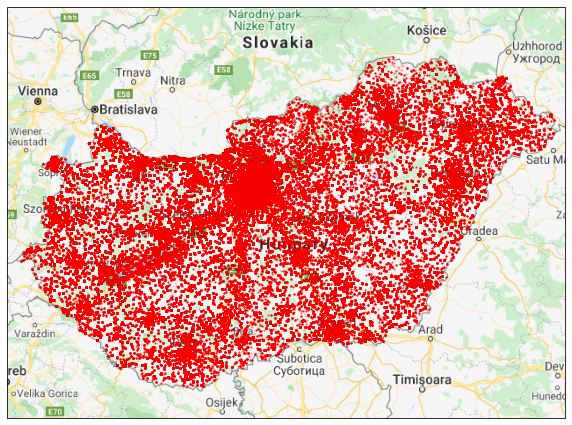

In [54]:
# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
xynps = ax.projection.transform_points( ccrs.Geodetic(), x=y_, y=x_)
plt.scatter( xynps[:,0], xynps[:,1], s=1, alpha=0.1, marker='o', color='red' )

### Investigate cleaned events

In [55]:
source+files_events[100]

'/mnt/raw_data/MT_MTA_NETWORK_EVENTS_20190311.csv.gz'

In [56]:
events_df = pd.read_csv( '/mnt2/data/csv/Events_20190311.csv.gz', delimiter=';', 
                         header=None, names=["event_datetime", "equipment_identifier", 
                                 "network_identifier", "event_type", "event_direction", 
                                 "device_tac"])
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,device_tac
0,158,5C800003,325471968,D,O,35337609.0
1,710,5C800003,7846060,D,O,35337609.0
2,718,5C800003,60444489,D,O,35337609.0
3,721,5C800003,1638694,D,O,35337609.0
4,721,5C800003,1638694,D,O,35337609.0


In [57]:
events_df["tower_idx"] = [ tower_to_int[i] for i in events_df.network_identifier.values ]
events_df.head()

,event_datetime,equipment_identifier,network_identifier,event_type,event_direction,device_tac,tower_idx
0,158,5C800003,325471968,D,O,35337609.0,39888
1,710,5C800003,7846060,D,O,35337609.0,8046
2,718,5C800003,60444489,D,O,35337609.0,12294
3,721,5C800003,1638694,D,O,35337609.0,4052
4,721,5C800003,1638694,D,O,35337609.0,4052


In [58]:
points_to_plot = []
for i in tqdm( range(0, events_df.shape[0], 25) ):
    points_to_plot.append( poligons_df.eov_idx.values[ np.searchsorted(poligons_df.tower_idx.values, events_df.tower_idx.values[i]) ] )

100%|██████████| 2957701/2957701 [01:20<00:00, 36793.73it/s]


In [59]:
x_, y_ = transformer.transform( xx=raster_coords[ points_to_plot ][:,1], yy=raster_coords[ points_to_plot ][:,0]  )
x_.shape, y_.shape

((2957701,), (2957701,))

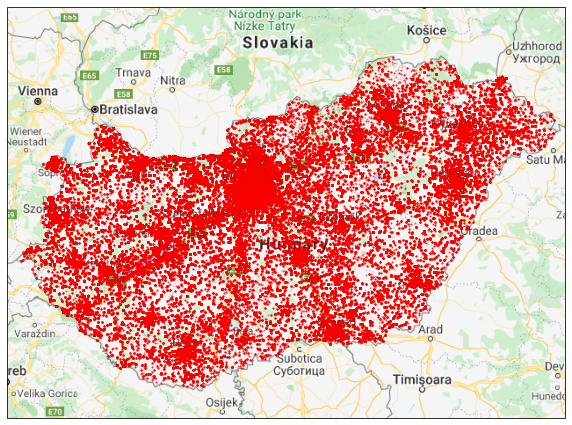

In [60]:
# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.GoogleTiles() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(10,18), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
xynps = ax.projection.transform_points( ccrs.Geodetic(), x=y_, y=x_)
plt.scatter( xynps[:,0], xynps[:,1], s=1, alpha=0.1, marker='o', color='red' )

### -- Skip until here --

### Lets see which towers are the most active ones

In [ ]:
events_df.groupby('network_identifier').count()

In [53]:
np.unique( poligons_df.network_element_type )

array(['A', 'B', 'C', 'D', 'E', 'U'], dtype=object)

In [59]:
poligons_df.groupby( by='network_element_type').count()

,network_identifier,eovx,eovy,dx,dy,eovx_num,eovy_num,eov_idx,tower_idx
network_element_type,,,,,,,,,
A,3585604,3585604,3585604,3585604,3585604,3585604,3585604,3585604,3585604
B,5738439,5738439,5738439,5738439,5738439,5738439,5738439,5738439,5738439
C,5490849,5490849,5490849,5490849,5490849,5490849,5490849,5490849,5490849
D,10909002,10909002,10909002,10909002,10909002,10909002,10909002,10909002,10909002
E,318201,318201,318201,318201,318201,318201,318201,318201,318201
U,3,3,3,3,3,3,3,3,3
